## Problem Definition

In [1]:
import scipy
import numpy as np
import gym
from gym import spaces
import torch

RANDOM_SEED = 42
SIGMA_NOISE = 0
torch.manual_seed(RANDOM_SEED)

from constants import DTYPE

def optimal_lqr_control(A, B, Q, R):

    '''
    Solve the continuous-time LQR problem given A, B, Q, R.

    Parameters
    ----------
    A : numpy.ndarray
        The state matrix.
    B : numpy.ndarray
        The control matrix.
    Q : numpy.ndarray
        The state cost matrix.
    R : numpy.ndarray
        The control cost matrix.

    Returns
    -------
    K : numpy.ndarray
        The optimal LQR gain.
    '''
    # Solve the Riccati equation
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)

    # Compute the LQR gain
    K = np.linalg.inv(R) @ B.T @ P

    return K

class CircleRotationEnv(gym.Env):

    def __init__(self,
                 s_init: np.array,
                 seed: int,
                 k_x=0,
                 k_y=0,
                 k_p=0,
                 q_x=1,
                 q_y=1,
                 q_r=0.2,
                 theta=0,
                 sigma_noise=SIGMA_NOISE):
        
        self.seed(seed)
        self.k_x = k_x
        self.k_y = k_y
        self.k_p = k_p
        self.q_x = q_x
        self.q_y = q_y
        self.q_r = q_r
        self.theta = theta
        self.state_dim = 2
        self.action_dim = 2
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)

        # Define system dynamics
        self.A = np.array([[-(k_x + k_p), 0.0],
                           [0.0, -(k_y + k_p)]])
        self.B_init = np.eye(2)
        self.B = self.B_init
    
        self.Q = np.array([[self.q_x, 0.0],
                      [0.0, self.q_y]])
        self.R = np.eye(2) * self.q_r

        self.s_0 = s_init
        self.s = self.s_0

        self.episode_length = 100
        self.step_count = 0
        self.goal_state = np.array([0,0], dtype=np.float32) #only used to check whether agent reached goal state.


    def reset(self):

        '''
        Reset the system to its initial state. Does not reset the rotation matrix.
        '''

        self.step_count = 0
        self.s = self.s_0.copy()
        return self.s
    

    def step(self, u):

        '''
        Step the system forward by one time step from state s with control input u. Returns the next state, the cost and whether the episode is done.
        '''


        self.s+= self.A @ self.s + self.B @ u
        self.s += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        reward = -(self.s @ self.Q @ self.s + u @ self.R @ u)
        self.step_count += 1

        if self.step_count == self.episode_length or np.allclose(self.s, self.goal_state, atol=0.1):
            done = True
            self.step_count = 0
        else:
            done = False

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]


    def rotate_S(self, theta):

        '''
        Rotates the matrix B by angle theta. Theta is in degrees, rather than radians.
        '''
        self.B = self.B_init

        theta = np.radians(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                    [np.sin(theta), np.cos(theta)]])
        # self.B = self.B @ rotation_matrix
        self.s_0 = rotation_matrix @ self.s_0


    def generate_evenly_spread_rotation_angles(self, N_tasks):

        '''
        Evenly spreads rotation angles between 0 and 360 degrees.

        Args:
            N_tasks (int): Number of tasks to generate.

        Returns:
            theta_values (np.array): Array of rotation angles in degrees.
        '''

        _min_angle = 0
        _max_angle = 360-360/N_tasks

        return np.linspace(_min_angle, _max_angle, N_tasks)


In [3]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Make the environment
s_0 = np.array([1,0], dtype=np.float32)
env = CircleRotationEnv(s_init=s_0, seed=RANDOM_SEED)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=os.cpu_count(), seed=RANDOM_SEED)

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1, seed=RANDOM_SEED)

# Train the model
model.learn(total_timesteps=50_000)

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | -18.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 802      |
|    time_elapsed    | 0        |
|    total_timesteps | 407      |
| train/             |          |
|    actor_loss      | -1.72    |
|    critic_loss     | 0.256    |
|    ent_coef        | 0.992    |
|    ent_coef_loss   | -0.0262  |
|    learning_rate   | 0.0003   |
|    n_updates       | 27       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41       |
|    ep_rew_mean     | -39.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 726      |
|    time_elapsed    | 1        |
|    total_timesteps | 781      |
| train/             |          |
|    actor_loss      | -1.52    |
|    critic_loss     | 0.342   

## Visualize Policy on New Tasks

In [92]:
def generate_circle_points(N):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N_tasks = 9
circle_points = generate_circle_points(N_tasks)
print(circle_points)

[[ 1.          0.        ]
 [ 0.76604444  0.64278761]
 [ 0.17364818  0.98480775]
 [-0.5         0.8660254 ]
 [-0.93969262  0.34202014]
 [-0.93969262 -0.34202014]
 [-0.5        -0.8660254 ]
 [ 0.17364818 -0.98480775]
 [ 0.76604444 -0.64278761]]


In [5]:
import matplotlib.pyplot as plt

def sample_traj_of_env(environment, trained_model):
    n_steps = 100
    obs = environment.reset()
    trajectory = []
    rewards = []
    actions = []
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action, _ = trained_model.predict(obs, deterministic=True)
        obs, reward, done, info = environment.step(action)

        actions.append(action)
        trajectory.append(obs.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    trajectory = np.array(trajectory)
    rewards = np.array(rewards)
    actions = np.array(actions)

    return trajectory, actions, rewards

trajs_all_tasks = []
actions_all_tasks = []

for circle_point in circle_points:
    test_env = CircleRotationEnv(s_init=circle_point, seed=RANDOM_SEED)
    traj, actions, rewards = sample_traj_of_env(test_env, model)
    trajs_all_tasks.append(traj)
    actions_all_tasks.append(actions)

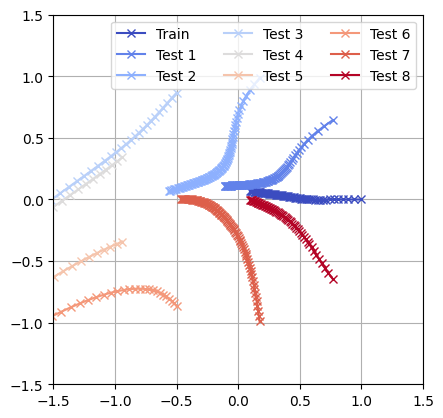

In [6]:
cmap = plt.get_cmap('coolwarm')
num_trajs = len(trajs_all_tasks)

for idx_traj, traj_task in enumerate(trajs_all_tasks):
    if idx_traj == 0:
        label="Train"
    else:
        label=f"Test {idx_traj}"
    color = cmap(idx_traj / max(1, num_trajs - 1))
    plt.plot(traj_task[:,0], traj_task[:,1], label=label, marker="x", color=color)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend(ncols=3)
plt.gca().set_aspect('equal')
plt.grid()

## Equivariant Policy

In [7]:
Lg = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Kg = lambda theta : np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) #Runs counter-clockwise! Not the same as Lg

def sample_traj_of_env_via_sym(task, base_policy, Kg, Lg):
    """Rolls out a base policy in a new task via equivariance."""
    Kg_inv = np.linalg.inv(Kg)
    Lg_inv = np.linalg.inv(Lg)

    trajectory = []
    rewards = []
    actions = []

    n_steps = 100
    obs_tilde = task.reset()
    trajectory.append(obs_tilde.copy())
    obs_base = Lg_inv @ obs_tilde

    for _ in range(n_steps):
        action_base, _ = base_policy.predict(obs_base, deterministic=True)
        action_tilde = Kg_inv @ action_base
        obs_tilde, reward, done, _ = task.step(action_tilde)

        obs_base = Lg_inv @ obs_tilde

        actions.append(action_tilde)
        trajectory.append(obs_tilde.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    return np.array(trajectory)

all_trajs_equ = []

for test_task_idx, test_goal_position in enumerate(circle_points):
    test_env = CircleRotationEnv(s_init=test_goal_position, seed=RANDOM_SEED)
    g_action = test_task_idx*2*np.pi/N_tasks
    Kg_test_task = Kg(g_action)
    Lg_test_task = Lg(g_action)

    traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=Kg_test_task, Lg=Lg_test_task)
    all_trajs_equ.append(traj_equ)

In [8]:
TEST_TASK_IDX = 1
test_task_goal = circle_points[TEST_TASK_IDX]
test_env = CircleRotationEnv(s_init=test_task_goal, seed=RANDOM_SEED)
g_action = TEST_TASK_IDX*2*np.pi/N_tasks

In [9]:
Kg_test_task = Kg(g_action)
Lg_test_task = Lg(g_action)

traj_task_1_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=Kg_test_task, Lg=Lg_test_task)

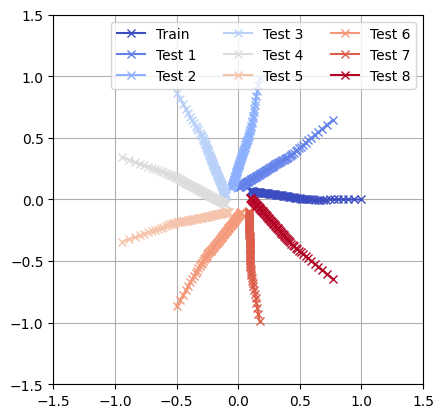

In [10]:
cmap = plt.get_cmap('coolwarm')
num_trajs = len(all_trajs_equ)

for idx_traj, traj_task_equ in enumerate(all_trajs_equ):
    if idx_traj == 0:
        label="Train"
    else:
        label=f"Test {idx_traj}"
    color = cmap(idx_traj / max(1, num_trajs - 1))
    plt.plot(traj_task_equ[:,0], traj_task_equ[:,1], label=label, marker="x", color=color)
    plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend(ncols=3)
plt.gca().set_aspect('equal')
plt.grid()

## Task Inference

- Given a trajectory in a new task sampled according to the base policy, we aim to find out what left-action generated this task.
- If they both start in the same state

In [129]:
import torch

def left_action_from_weight(generator, weight):
    """Computes the left-action of a Matrix-Lie Group from its infinitesimal Generator given a weight."""
    return torch.linalg.matrix_exp(weight * generator)

def proj_traj_from_base_to_task(s_0, base_transition_func, base_policy, Lg, traj_length=100):
    """Samples a trajectory in the base environment according to the base policy but projects each state and action to a task tilde induced by Lg.
    s_0: initial state from the base environment
    base_transition_func: transition function of the base environment
    base_policy: Callable, optimal policy in the base environment
    Lg: acts on S, from base to tilde
    """
    trajectory = []
    actions = []

    s_0_tilde = Lg @ s_0
    s_tilde = s_0_tilde

    for idx in range(traj_length):

        trajectory.append(s_tilde)
        a_tilde_np, _ = base_policy.predict(s_tilde.detach().numpy(), deterministic=True)
        a_tilde = torch.tensor(a_tilde_np, requires_grad=False)
        # a_base = Kg_inv @ a_tilde

        #TODO: We step in the new task, this is probably very error prone as we can't estimate the transition function there.
        s_tilde = base_transition_func(s_tilde, a_tilde)
        # s_tilde = Lg @ s_base

        # actions.append(a_tilde.copy())

    return torch.stack(trajectory, dim=0), actions

In [111]:
generator_lg = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE) #weight w to generate a left-action is the rotation in radians
generator_kg = torch.tensor([[0, 1], [-1, 0]], dtype=DTYPE)

weight_test_task = torch.tensor(TEST_TASK_IDX*2*np.pi/N_tasks, dtype=DTYPE)
weight_test_task_np = np.array(TEST_TASK_IDX*2*np.pi/N_tasks)

lg_task_1 = left_action_from_weight(generator=generator_lg, weight=weight_test_task).detach().numpy()
kg_task_1 = left_action_from_weight(generator=generator_kg, weight=weight_test_task).detach().numpy()

In [112]:
def base_transition_func_circle_np(state: torch.tensor, action: torch.tensor, A: torch.tensor, B: torch.tensor):
    """Transition function from the base environment."""
    state += A @ state + B @ action
    state += np.random.normal(loc=0, scale=SIGMA_NOISE, size=2) if SIGMA_NOISE > 0 else 0
    return state

tran_fn = lambda s, a : base_transition_func_circle_np(s, a, A=env.A, B=env.B)

traj_proj_task_1, rewards_proj_task_1, actions_proj_task_1 = proj_traj_from_base_to_task(s_0 = np.array([1.0,0.0]),
                            base_transition_func = tran_fn,
                            base_policy=model,
                            Kg=kg_task_1,
                            Lg=lg_task_1)

In [93]:
idx_test_task = 1
traj_base = trajs_all_tasks[0]
traj_test = trajs_all_tasks[idx_test_task]

actions_test = actions_all_tasks[idx_test_task]

In [114]:
print("s 0 new task: ", traj_test[0,:])
print("a 0 new task", actions_all_tasks[idx_test_task][0,:])
print("s 1 new task: ", traj_test[1,:])

print("s 0 projection base task: ", traj_proj_task_1[0,:])
print("a 0 projection base task", actions_proj_task_1[0,:])
print("s 1 projection base task: ", traj_proj_task_1[1,:])

s 0 new task:  [0.76604444 0.64278761]
a 0 new task [-0.06655654 -0.04697367]
s 1 new task:  [0.6994879  0.59581394]
s 0 projection base task:  [0.7660445  0.64278758]
a 0 projection base task [-0.06655654 -0.04697367]
s 1 projection base task:  [0.69948795 0.5958139 ]


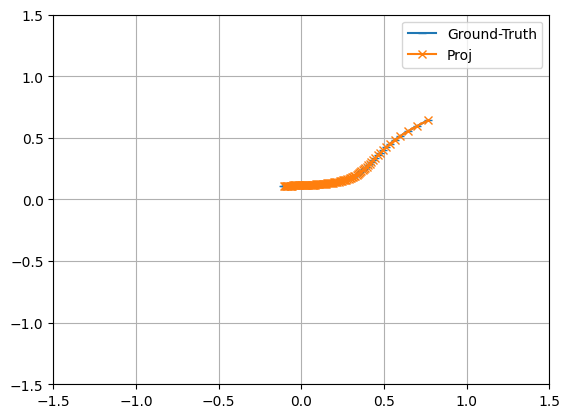

In [115]:
plt.plot(traj_test[:,0], traj_test[:,1], label="Ground-Truth", marker="_")
plt.plot(traj_proj_task_1[:,0], traj_proj_task_1[:,1], label="Proj", marker="x")
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()

## Infer Task via Gradient Flow on the Weight

In [146]:
import torch
from tqdm import tqdm


def left_action_from_weight(generator, weight):
    """Computes the left-action of a Matrix-Lie Group from its infinitesimal Generator given a weight."""
    return torch.linalg.matrix_exp(weight * generator)

def proj_traj_from_base_to_task(s_0, base_transition_func, base_policy, Lg, traj_length=100):
    """Samples a trajectory in the base environment according to the base policy but projects each state and action to a task tilde induced by Lg.
    s_0: initial state from the base environment
    base_transition_func: transition function of the base environment
    base_policy: Callable, optimal policy in the base environment
    Lg: acts on S, from base to tilde
    """
    trajectory = []
    actions = []

    s_0_tilde = Lg @ s_0
    s_tilde = s_0_tilde

    for idx in range(traj_length):

        trajectory.append(s_tilde)
        a_tilde_np, _ = base_policy.predict(s_tilde.detach().numpy(), deterministic=True)
        a_tilde = torch.tensor(a_tilde_np, requires_grad=False)
        # a_base = Kg_inv @ a_tilde

        #TODO: We step in the new task, this is probably very error prone as we can't estimate the transition function there.
        s_tilde = base_transition_func(s_tilde, a_tilde)
        # s_tilde = Lg @ s_base

        # actions.append(a_tilde.copy())

    return torch.stack(trajectory, dim=0), actions

task_w_0 = torch.nn.Parameter(torch.randn(1))
task_w_optimizer = torch.optim.Adam([task_w_0], lr=0.0045)

A_torch = torch.tensor(env.A, dtype=DTYPE)
B_torch = torch.tensor(env.B, dtype=DTYPE)
task_traj_torch = torch.tensor(traj_test)

def base_transition_func_circle_torch(state: torch.tensor, action: torch.tensor, A: torch.tensor, B: torch.tensor):
    """Transition function from the base environment."""
    state += A @ state + B @ action
    state += torch.randn(2)* SIGMA_NOISE**0.5 if SIGMA_NOISE > 0 else 0
    return state

def task_inference_loss_fn(task_traj: torch.tensor, proj_traj: torch.tensor):
    """Simple MSE loss comparing a trajectory from the new task and the trajectory projected from the base MDP."""
    min_length = min(task_traj.shape[0], proj_traj.shape[0])
    task_traj = task_traj[:min_length, :]
    proj_traj = proj_traj[:min_length, :]
    return torch.sum(torch.norm(task_traj - proj_traj, dim=1), dim=0)

N_GRADIENT_STEPS = 15000
tran_fn_th = lambda s, a : base_transition_func_circle_torch(s, a, A=torch.tensor(env.A, dtype=DTYPE), B=torch.tensor(env.B, dtype=DTYPE))

pbar = tqdm(range(N_GRADIENT_STEPS), desc="Computing Left-Action Weight...")
for _ in pbar:

    # Compute group actions given current weight
    lg_task_1 = left_action_from_weight(generator=generator_lg, weight=task_w_0)
    kg_task_1 = left_action_from_weight(generator=generator_kg, weight=task_w_0)

    # Project policy into current task
    proj_traj, _ = proj_traj_from_base_to_task(s_0 = torch.tensor([1.0,0.0]),
                            base_transition_func = tran_fn_th,
                            base_policy=model,
                            Lg=lg_task_1)
    
    # Compute loss
    loss = task_inference_loss_fn(task_traj_torch, proj_traj = proj_traj)

    # Update weight
    task_w_optimizer.zero_grad()
    loss.backward()
    task_w_optimizer.step()

    pbar.set_description(f"Loss: {loss.item():.4f}")


Loss: 27.5631:   0%|          | 34/15000 [00:01<09:53, 25.23it/s]         


KeyboardInterrupt: 

In [145]:
proj_traj_from_base_to_task(s_0 = torch.tensor([1.0,0.0]),
                            base_transition_func = tran_fn_th,
                            base_policy=model,
                            Lg=lg_task_1)

(tensor([[-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0697,  0.0994],
         [-0.0